In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import scipy as sp
# import scipy.sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
# import graphlab as gl
import sklearn.metrics
import ast
%matplotlib inline

from matrix_factorization_recommender import MatrixFactorizationRecommender
from simple_averaging_recommender import SimpleAveragingRecommender

from scipy.sparse import csr_matrix
from baseline_calculator import DecoupledRegularizedBaselineCalculator

businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# phoenix_reviews = phoenix_reviews.iloc[0:20000]
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)
reviews_train, reviews_valid = train_test_split(reviews_train,train_size=0.5)

In [2]:
print reviews_train.shape
print reviews_valid.shape
print reviews_test.shape

(226727, 6)
(226727, 6)
(194338, 6)


In [3]:
phoenix_restaurants = phoenix_restaurants[phoenix_restaurants['business_id'].isin(reviews_train.business_id)]
phoenix_users = phoenix_users[phoenix_users['user_id'].isin(reviews_train.user_id)]

In [4]:
bc = DecoupledRegularizedBaselineCalculator()
bc.fit(reviews_train, busi_reg_strength=2.5, user_reg_strength=5)
bc.transform(reviews_train, key='baseline_stars')
bc.transform(reviews_test, key='baseline_stars')
bc.transform(reviews_valid, key='baseline_stars')
bc.baseline_rmse(reviews_test)

1.2449263988831947

In [5]:
### phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['business_id',
                     'attributes',
                     'categories',
                     'city',
#                      'hours', # looks complicated
                     'latitude',
                     'longitude',
                     'neighborhoods',
                     'open',
                     'review_count',
                     'stars']
phoenix_restaurants = phoenix_restaurants[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    attribs = flatten(ast.literal_eval(row.attributes))
    categories = ast.literal_eval(row.categories)
    neighborhoods = ast.literal_eval(row.neighborhoods)
    attributes = pd.DataFrame.from_dict(attribs, orient='columns')
    categories = pd.DataFrame.from_dict(dict([[c, [1]] for c in categories]))
    neighborhoods = pd.DataFrame.from_dict(dict([[n, [1]] for n in neighborhoods]))
    city = row.city
    row = row.drop(['attributes', 'categories', 'neighborhoods', 'city'])
    city = pd.DataFrame([1], index=[city])
    if (neighborhoods.shape[0] > 0) & (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], pd.get_dummies(attributes).iloc[0], city.iloc[0]), axis=0)
    elif (neighborhoods.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], city.iloc[0]), axis=0)
    elif (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], pd.get_dummies(attributes).iloc[0], city.iloc[0]), axis=0)
    else:
        result = pd.concat((row, categories.iloc[0], city.iloc[0]), axis=0)
    return result.astype(np.float32).to_sparse()

phoenix_bus_update = phoenix_restaurants.apply(parse_data,axis=1,)
# phoenix_update = pd.concat((phoenix_update, pd.get_dummies(phoenix_update['city'])), axis=1)
# phoenix_update = phoenix_update.drop('city', axis=1)
phoenix_bus_update = phoenix_bus_update.fillna(0)
phoenix_bus_update.head(2)

,0,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,...,Wine Tasting Room,Wine Tours,Wineries,Yoga,business_id,latitude,longitude,open,review_count,stars
2377,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2377,33.479481,-112.073677,1,20,3.0
2378,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2378,33.468548,-112.075089,1,6,3.5


In [6]:
# phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['user_id',
                    'average_stars',
                     'compliments',
                     'elite',
                     'fans',
                    'votes',
#                      'hours', # looks complicated
                     'review_count',
#                      'yelping_since'
                      ]
phoenix_users = phoenix_users[columns_of_interest]

def parse_data(row):
    compliments = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.compliments)), orient='columns')
    votes = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.votes)), orient='columns')
    elite = pd.DataFrame.from_dict(dict([['elite_{}'.format(e), [1]] for e in ast.literal_eval(row.elite)]))
    
    compliments.columns = ['compliment_' + c for c in compliments.columns]
    votes.columns = ['vote' + v for v in votes.columns]
    
    row = row.drop(['compliments', 'votes', 'elite'])
 
    if (elite.shape[0] > 0) & (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0],  compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (votes.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], compliments.iloc[0]), axis=0)
    elif (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0], compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0]), axis=0)
    elif (votes.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0]), axis=0)    
    elif (compliments.shape[0] > 0):
        result = pd.concat((row, compliments.iloc[0]), axis=0)
    else:
        result = row
    return result.astype(np.float32).to_sparse()

phoenix_users_update = phoenix_users.apply(parse_data,axis=1,)
phoenix_users_update = phoenix_users_update.fillna(0)
phoenix_users_update.head(2)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite_2013,elite_2014,elite_2015,elite_2016,fans,review_count,user_id,votecool,votefunny,voteuseful
1,3.67,1675,204,594,1111,38,137,611,361,970,...,1,1,1,1,1345,1292,1,12091,8399,15242
2,3.68,134,22,96,99,4,18,79,27,86,...,1,1,1,0,105,395,2,657,722,1349


In [7]:
for business_id, business in phoenix_bus_update.iterrows():
    reviews_in_train = reviews_train[reviews_train.business_id == business_id]
    phoenix_bus_update.set_value(business_id, 'stars', reviews_in_train.stars.mean())
    
for user_id, user in phoenix_users_update.iterrows():
    reviews_in_train = reviews_train[reviews_train.user_id == user_id]
    phoenix_users_update.set_value(user_id, 'average_stars', reviews_in_train.stars.mean())

In [8]:
print reviews_train.shape
print reviews_valid.shape
print reviews_test.shape

(226727, 7)
(226727, 7)
(194338, 7)


In [9]:
combined_reviews_train = pd.merge(pd.merge(
        reviews_train,phoenix_bus_update.fillna(0), on='business_id', suffixes=('','_business'), how='left'),
        phoenix_users_update, on='user_id', suffixes=('','_user'), how='left')
combined_reviews_train = combined_reviews_train.fillna(0)
combined_reviews_valid = pd.merge(pd.merge(
        reviews_valid,phoenix_bus_update.fillna(0), on='business_id', suffixes=('','_business'), how='left'),
        phoenix_users_update, on='user_id', suffixes=('','_user'), how='left')
combined_reviews_valid = combined_reviews_valid.fillna(0)

In [10]:
combined_reviews_test = pd.merge(pd.merge(reviews_test,
    phoenix_bus_update.fillna(0), on='business_id', suffixes=('','_business'), how='left'),
    phoenix_users_update, on='user_id', suffixes=('','_user'), how='left')
combined_reviews_test = combined_reviews_test.fillna(0)

In [11]:
print combined_reviews_train.shape
print combined_reviews_test.shape

(226727, 362)
(194338, 362)


In [12]:
def strip_cols(df):
    return df.drop(['user_id',
             'business_id',  
#              'average_stars', 
#              'stars_business',
             'stars',
             'baseline_stars'], axis=1)

1.24044283164


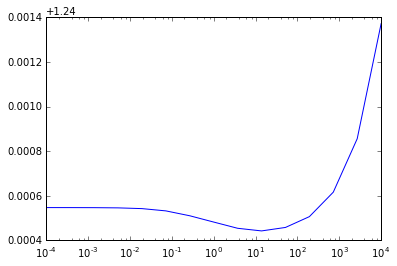

In [13]:
scores = []
xs = np.logspace(-4,4,15)
for i in xs:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(strip_cols(combined_reviews_valid), combined_reviews_valid.baseline_stars)
    x_pred = las.predict(strip_cols(combined_reviews_test))
    s = np.sqrt(sklearn.metrics.mean_squared_error(combined_reviews_test.stars,
                                           bc.inverse_transform(reviews_test, x_pred)))
    scores.append(s)

plt.semilogx(xs, scores)

print np.min(scores)
baseline_val = xs[np.argmin(scores)]

2.20885732095


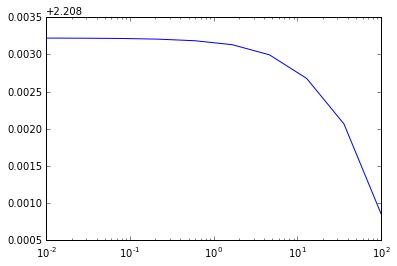

In [14]:
scores = []
xs = np.logspace(-2,2,10)
for i in xs:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(strip_cols(combined_reviews_train), combined_reviews_train.stars)
    x_pred = las.predict(strip_cols(combined_reviews_test))
    s = np.sqrt(sklearn.metrics.mean_squared_error(combined_reviews_test.stars,x_pred))
    scores.append(s)
plt.semilogx(xs, scores)

print np.min(scores)
val = xs[np.argmin(scores)]

In [15]:
las = sklearn.linear_model.Ridge(alpha=val)
las.fit(strip_cols(combined_reviews_train), combined_reviews_train.stars)
strip_cols(combined_reviews_test).columns[np.abs(las.coef_)>0.05]

Index([u'Airport Lounges', u'Cheese Shops', u'Cinema', u'Colombian',
       u'Cupcakes', u'Fish & Chips', u'Fondue', u'Food Delivery Services',
       u'Food Stands', u'Fruits & Veggies', u'Grocery', u'Health Markets',
       u'Internet Cafes', u'Open 24 Hours', u'Party & Event Planning',
       u'Peruvian', u'Smoking_yes', u'latitude', u'stars_business',
       u'average_stars'],
      dtype='object')

In [16]:
las = sklearn.linear_model.Ridge(alpha=baseline_val)
las.fit(strip_cols(combined_reviews_valid), combined_reviews_valid.baseline_stars)
strip_cols(combined_reviews_test).columns[np.abs(las.coef_)>0.05]

Index([                       0,           u'Active Life',
         u'Adult Entertainment',                u'Afghan',
                     u'African',   u'Ages Allowed_21plus',
        u'Ages Allowed_allages', u'Alcohol_beer_and_wine',
                u'Alcohol_none',       u'Ambience_casual',
       ...
                       u'Uzbek', u'Venues & Event Spaces',
                u'Whiskey Bars',            u'Wi-Fi_paid',
           u'Wine Tasting Room',              u'Wineries',
                        u'Yoga',        u'stars_business',
                  u'elite_2005',            u'elite_2016'],
      dtype='object', length=178)

In [17]:
# tuning various hyperparameters
import sklearn.ensemble
model = sk.ensemble.RandomForestRegressor(n_estimators=200)
model.fit(strip_cols(combined_reviews_valid), combined_reviews_valid.baseline_stars)
x_pred = model.predict(strip_cols(combined_reviews_test))
s = np.sqrt(sklearn.metrics.mean_squared_error(combined_reviews_test.stars,
                                       bc.inverse_transform(reviews_test, x_pred)))
print s

1.24744226546


In [18]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(50,200,10), 'max_features':('log2'), 'max_depth':(5,10)}
clf = GridSearchCV(model, parameters)
clf.fit(strip_cols(combined_reviews_valid), combined_reviews_valid.baseline_stars)

ValueError: Parameter values for parameter (max_features) need to be a sequence(but not a string) or np.ndarray.

In [ ]:
clf.best_estimator_

In [ ]:
t = clf.best_estimator_
t.fit(strip_cols(combined_reviews_valid), combined_reviews_valid.baseline_stars)

In [ ]:
x_pred = t.predict(strip_cols(combined_reviews_test))
s = np.sqrt(sklearn.metrics.mean_squared_error(combined_reviews_test.stars,
                                       bc.inverse_transform(reviews_test, x_pred)))
s